In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

import branca
import branca.colormap as cm



from wetterdienst import Wetterdienst
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution

from datetime import datetime, timedelta


def station_temp(name, start_date, end_date):
    request = DwdObservationRequest(parameter=[DwdObservationDataset.TEMPERATURE_AIR],
                                resolution=DwdObservationResolution.MINUTE_10,
                                start_date=start_date,
                                end_date=end_date,
                                ).filter_by_name(name=name)

    df_res = request.values.all().df.dropna()

    df_Temp=df_res[df_res.parameter=="temperature_air_mean_200"].drop(['dataset', 'parameter', 'quality'], axis=1)
    df_Temp.rename(columns={'value':'T'}, inplace=True)
    df_dew=df_res[df_res.parameter=="temperature_dew_point_mean_200"].drop(['station_id', 'dataset', 'parameter', 'quality'], axis=1)
    
    df_dew.rename(columns={'value':'Td'}, inplace=True)
    
    df_Temp.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    
    df_dew.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    df_out=df_Temp.merge(df_dew, how='left', left_index=True, right_index=True)

    df_out["time"]=pd.to_datetime(df_Temp.date, format="%Y-%m-%d %H:%M:%S%z").dt.tz_localize(None)
    df_out.rename(columns{"time":"Time"})
    #df_out["SEC"]=pd.to_timedelta(df_Temp.date).dt.total_seconds()
    df_out.set_index(df_out["Time"], inplace=True)
    #df_out.drop(["date"], axis=1)
    #df_out.set_index("time", inplace=True)
    df_out=df_out.drop(["date_x", "date_y"], axis=1)
    df_out["T"]=df_out["T"]-273.15
    df_out["Td"]=df_out["Td"]-273.15
    
    return df_out



SyntaxError: invalid syntax (2036074234.py, line 40)

In [71]:

#fn="./dcsv/Leipzig - Leipzig 2022-06-02T17_47_56+0200_Jakob.csv"
fn="./dcsv/Leipzig - Leipzig 2022-05-25T12_01_27+0200.csv"
station="Leipzig-Holzhausen"
#station="Leipzig/Halle"

ds = pd.read_csv(fn)

#ds=ds[50:-50]
print(ds)

ds.Time=pd.to_datetime(ds.Time, format="%Y-%m-%dT%H:%M:%S%z").dt.tz_localize(None)
#print(ds)
#ds.rename(columns={'Time':'time'}, inplace=True)

ds.set_index(pd.DatetimeIndex(ds["Time"]), inplace=True)
ds=ds[ds["Speed"]>10]
print(ds)


                         Time   Latitude  Longitude  Altitude  Speed  \
0    2022-05-25T12:03:27+0200  51.320851  12.385793       107     14   
1    2022-05-25T12:03:31+0200  51.320810  12.385595       106     16   
2    2022-05-25T12:03:34+0200  51.320775  12.385366       106     17   
3    2022-05-25T12:03:40+0200  51.320731  12.384969       106     17   
4    2022-05-25T12:03:43+0200  51.320706  12.384757       105     16   
..                        ...        ...        ...       ...    ...   
628  2022-05-25T12:37:49+0200  51.274210  12.315454        98      0   
629  2022-05-25T12:37:52+0200  51.274211  12.315448        98      0   
630  2022-05-25T12:37:55+0200  51.274211  12.315447        98      0   
631  2022-05-25T12:37:57+0200  51.274211  12.315447        98      0   
632  2022-05-25T12:38:01+0200  51.274211  12.315447        98      0   

     Temperature  Humidity  Pressure  Dew point Radiation Inversion  Humidex  
0           18.6        52      1001        9.2         

In [72]:
map_OSM = folium.Map(location=[51.33,12.39], zoom_start=13, tiles='Stamen Terrain')
map_OSM

In [73]:


lat = ds.Latitude
lon = ds.Longitude
t = ds['Temperature']
print(t)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'green','yellow', 'orange', 'red','firebrick'],
                             index=[0,5,8,10,12,15,20,25],
                             vmin = -5, vmax=30,
                            # tick_labels = [-10,0,10,20,30,40],
                            # scale_width= 800, scale_height=20,
                             caption=r'Temperature [°C]')

fg = folium.FeatureGroup() 
for pt in ds.index:
                  
    color = colormap(t[pt])              
    fg.add_child(folium.CircleMarker(location=[lat[pt],lon[pt]],
                                     radius=4,
                                     fill=True,
                                     color=color,
                                     fill_color=color))
    
    
    
    
map_OSM.add_child(fg)
#map_OSM.add_child(colormap)

map_OSM

Time
2022-05-25 12:03:27    18.6
2022-05-25 12:03:31    18.8
2022-05-25 12:03:34    18.8
2022-05-25 12:03:40    19.0
2022-05-25 12:03:43    19.0
                       ... 
2022-05-25 12:37:19    17.6
2022-05-25 12:37:22    17.6
2022-05-25 12:37:25    18.1
2022-05-25 12:37:28    17.7
2022-05-25 12:37:31    17.8
Name: Temperature, Length: 576, dtype: float64


In [75]:
start_date=datetime.strftime(min(ds.Time), format="%Y-%m-%d")
end_date=datetime.strftime(max(ds.Time)+np.timedelta64(1, 'D'), format="%Y-%m-%d")

DWD=station_temp(station, start_date, end_date)



In [76]:
#df_compared=ds.merge(Holzhausen, how="outer", sort=True, left_index=True, right_index=True)
df_compared=ds.merge(DWD, how="outer", sort=True, left_index=True, right_index=True)

df_compared=df_compared.drop(["Time", "time"], axis=1)

df_compared["T"]=df_compared["T"].interpolate(method="time", inplace=False, axis=0)
df_compared["Td"]=df_compared["Td"].interpolate(method="time", inplace=False, axis=0)
df_compared["T_diff"]=df_compared["Temperature"]-df_compared["T"]
print(df_compared)


                     Latitude  Longitude  Altitude  Speed  Temperature  \
2022-05-25 00:00:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 00:10:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 00:20:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 00:30:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 00:40:00       NaN        NaN       NaN    NaN          NaN   
...                       ...        ...       ...    ...          ...   
2022-05-25 23:20:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 23:30:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 23:40:00       NaN        NaN       NaN    NaN          NaN   
2022-05-25 23:50:00       NaN        NaN       NaN    NaN          NaN   
2022-05-26 00:00:00       NaN        NaN       NaN    NaN          NaN   

                     Humidity  Pressure  Dew point Radiation Inversion  \
2022-05-25 00:00:00       NaN       N

Text(0.5, 0.98, 'Zeitreihe Messfahrt')

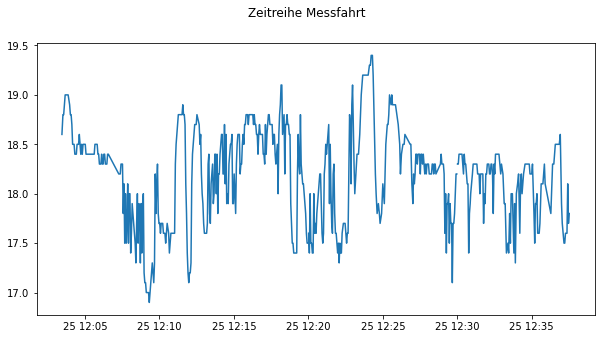

In [77]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["Temperature"], label="T Track")
fig.suptitle("Zeitreihe Messfahrt")

Text(0.5, 0.98, 'T Leipzig-Holzhausen')

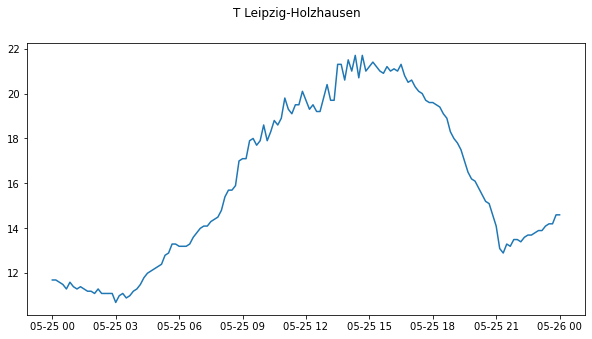

In [78]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
fig.suptitle("T "+station)

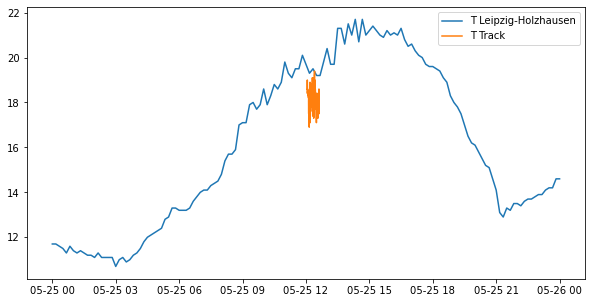

In [79]:

fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
ax.plot(df_compared.Temperature, label="T Track")
ax.legend()

(19137.502395833333, 19137.52605324074)

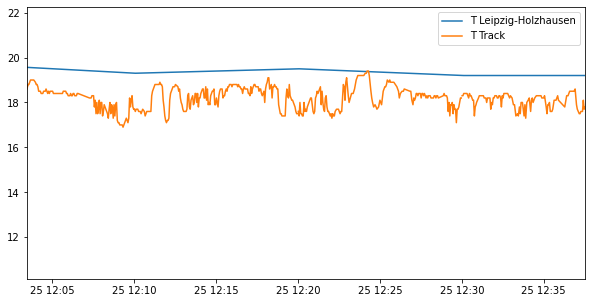

In [80]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
ax.plot(df_compared["Temperature"], label="T Track")
ax.legend()
ax.set_xlim([min(ds.Time),max(ds.Time) ])

Text(0.5, 0.98, 'Temperaturdifferenz Messfahrt - Leipzig-Holzhausen')

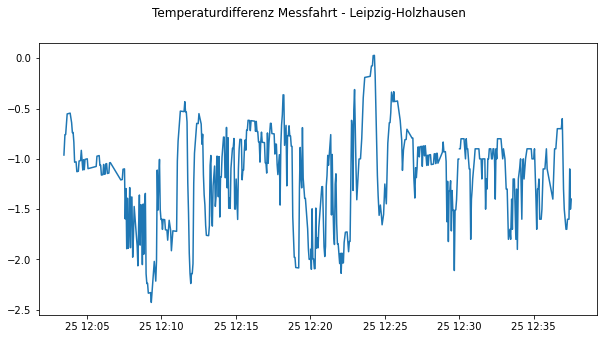

In [81]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared.T_diff)
fig.suptitle("Temperaturdifferenz Messfahrt - "+station)

In [83]:
map_OSM2 = folium.Map(location=[51.33,12.39], zoom_start=13, tiles='Stamen Terrain')


lat = ds.Latitude
lon = ds.Longitude
t = df_compared['T_diff']
print(t)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'green','yellow', 'orange', 'red','firebrick'],
                             index=[-1,-0.5, 0, 0.5, 1,2,5, 7],
                             vmin = -5, vmax=30,
                            # tick_labels = [-10,0,10,20,30,40],
                            # scale_width= 800, scale_height=20,
                             caption=r'Temperature [°C]')

fg = folium.FeatureGroup() 
for pt in ds.index:
                  
    color = colormap(t[pt])              
    fg.add_child(folium.CircleMarker(location=[lat[pt],lon[pt]],
                                     radius=4,
                                     fill=True,
                                     color=color,
                                     fill_color=color))
    
    
    
    
map_OSM2.add_child(fg)
#map_OSM.add_child(colormap)

map_OSM2

2022-05-25 00:00:00   NaN
2022-05-25 00:10:00   NaN
2022-05-25 00:20:00   NaN
2022-05-25 00:30:00   NaN
2022-05-25 00:40:00   NaN
                       ..
2022-05-25 23:20:00   NaN
2022-05-25 23:30:00   NaN
2022-05-25 23:40:00   NaN
2022-05-25 23:50:00   NaN
2022-05-26 00:00:00   NaN
Name: T_diff, Length: 721, dtype: float64
